# An Image Is Worth 16x16 Words _ Transformers for Image Recognition at Scale

## 0. Paper

### Info
* TItle : An Image Is Worth 16x16 Words _ Transformers for Image Recognition at Scale
* Author : Alexey Dosovitskiy
* Link : https://arxiv.org/pdf/2010.11929.pdf

### Summary
* 이미지를 여러 patch로 분리해 token처럼 사용
* transformer 모델을 통해 image recognition 수행

### Features
* dataset : cifar10
* test acc가 0.5 수준에서 멈춰있다. 구현 상의 문제는 없는 것 같은데, 정확히 어떤 문제인지 알 수 없다. 논문에서 작은 이미지에서 학습이 제대로 안 된다고 언급한 부분에 해당하는 걸까

## 1. Setting

In [1]:
# Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K

In [244]:
# Hyperparameters
CONFIG = {
    'base_dir' : '/content/drive/Shared drives/Yoon/Project/Doing/Deep Learning Paper Implementation',
    'drop_rate' : 0.1,
    'num_head' : 4,
    'num_layer' : 16,
    'model_dim' : 512,
    'patch_size' : 8,
    'batch_size' : 256,
    'epoch_size' : 100
}

## 2. Data

In [245]:
class Dataloader(tf.keras.utils.Sequence):
    def __init__(self, x, y, mode):
        self.x = x
        self.y = y
        self.mode = mode
        self.on_epoch_end()
    
    def __len__(self):
        return np.ceil(len(self.x) / CONFIG['batch_size']).astype(np.int32)
    
    def on_epoch_end(self):
        if self.mode == 'train':
            self.indices = np.random.permutation(len(self.x))
        else:
            self.indices = np.arange(len(self.x))
    
    def make_patch(self, x):
        patch = []
        batch_size = x.shape[0]
        seq_len = x.shape[1] // CONFIG['patch_size']
        for i in range(seq_len):
            _patch = x[:, CONFIG['patch_size']*i:CONFIG['patch_size']*(i+1), CONFIG['patch_size']*i:CONFIG['patch_size']*(i+1), :]
            _patch = np.reshape(_patch, (batch_size, -1))
            patch.append(_patch)
        patch = np.stack(patch, axis=1)
        return patch

    def __getitem__(self, idx):
        batch_idx = self.indices[CONFIG['batch_size'] * idx : CONFIG['batch_size'] * (idx+1)]
        batch_x = self.x[batch_idx]
        batch_x = self.make_patch(batch_x)
        batch_x = batch_x.astype(np.float32) / 255.0
        batch_y = self.y[batch_idx][:,0]
        return batch_x, batch_y

In [246]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [247]:
train_loader = Dataloader(x_train, y_train, 'train')
test_loader = Dataloader(x_test, y_test, 'test')

In [248]:
x, y = train_loader.__getitem__(0)
x.shape, y.shape

((256, 4, 192), (256,))

## 3. Model

In [249]:
class EmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, model_dim, seq_len):
        super(EmbeddingLayer, self).__init__()
        self.cls = tf.Variable(tf.random.normal((1, 1, model_dim)))
        self.embedding = tf.keras.layers.Dense(model_dim)
        self.pos = tf.Variable(tf.random.normal((1, seq_len+1, model_dim)))

    def call(self, x):
        batch_size = tf.shape(x)[0]
        x = self.embedding(x)
        cls = tf.repeat(self.cls, batch_size, axis=0)
        x = tf.concat([cls, x], axis=1)
        x += self.pos
        return x


class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, model_dim, num_head, drop_rate):
        super(MultiHeadAttention, self).__init__()
        self.model_dim = model_dim
        self.num_head = num_head
        self.projection_dim = self.model_dim // self.num_head
        assert self.model_dim % self.num_head == 0

        self.qw = tf.keras.layers.Dense(self.model_dim)
        self.kw = tf.keras.layers.Dense(self.model_dim)
        self.vw = tf.keras.layers.Dense(self.model_dim)
        self.w = tf.keras.layers.Dense(self.model_dim)
        self.dropout = tf.keras.layers.Dropout(drop_rate)
    
    def attention(self, q, k ,v, mask):
        dim = tf.cast(tf.shape(q)[-1], tf.float32)
        score = tf.matmul(q, k, transpose_b=True)
        scaled_score = score / tf.math.sqrt(dim)

        if mask is not None:
            scaled_score += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_score)
        attention_outputs = tf.matmul(attention_weights, v)
        return attention_outputs, attention_weights
    
    def split_heads(self, x):
        batch_size = tf.shape(x)[0]
        x = tf.reshape(x, (batch_size, -1, self.num_head, self.projection_dim))
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        return x
    
    def combine_heads(self, x):
        batch_size = tf.shape(x)[0]
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        x = tf.reshape(x, (batch_size, -1, self.model_dim))
        return x
    
    def call(self, q, k, v, mask=None):
        q, k, v = self.qw(q), self.kw(k), self.vw(v)
        q, k, v = self.split_heads(q), self.split_heads(k), self.split_heads(v)
        outputs, weights = self.attention(q, k, v, mask)
        outputs = self.combine_heads(outputs)
        outputs = self.w(outputs)
        outputs = self.dropout(outputs)
        return outputs

class FeedForwardNetwork(tf.keras.layers.Layer):
    def __init__(self, model_dim, drop_rate):
        super(FeedForwardNetwork, self).__init__()
        self.dense1 = tf.keras.layers.Dense(model_dim)
        self.dropout1 = tf.keras.layers.Dropout(drop_rate)
        self.dense2 = tf.keras.layers.Dense(model_dim)
        self.dropout2 = tf.keras.layers.Dropout(drop_rate)

    @staticmethod
    def gelu(x):
        cdf = 0.5 * (1.0 + tf.math.erf(x / tf.sqrt(2.0)))
        return x * cdf

    def call(self, x):
        x = self.dense1(x)
        x = self.gelu(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        x = self.dropout2(x)
        return x

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, model_dim, num_head, drop_rate):
        super(EncoderLayer, self).__init__()
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.mha = MultiHeadAttention(model_dim, num_head, drop_rate)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.ffn = FeedForwardNetwork(model_dim, drop_rate)

    def call(self, x, training):
        inputs = x
        x = self.norm1(x)
        x = self.mha(x, x, x)
        x += inputs

        inputs = x
        x = self.norm2(x)
        x = self.ffn(x)
        x += inputs
        return x

class OutputLayer(tf.keras.layers.Layer):
    def __init__(self, num_class):
        super(OutputLayer, self).__init__()
        self.norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dense = tf.keras.layers.Dense(num_class, activation='softmax')
    
    def call(self, x):
        x = self.norm(x[:, 0, :])
        outputs = self.dense(x)
        return outputs

class Model(tf.keras.Model):
    def __init__(self, seq_len,  num_class):
        super(Model, self).__init__()
        self.embedding = EmbeddingLayer(CONFIG['model_dim'], seq_len)
        self.encoders = [EncoderLayer(CONFIG['model_dim'], CONFIG['num_head'], CONFIG['drop_rate']) for _ in range(CONFIG['num_layer'])]
        self.output_layer = OutputLayer(num_class)
    
    def call(self, x, training):
        x = self.embedding(x)
        for i in range(CONFIG['num_layer']):
            x = self.encoders[i](x, training=training)
        outputs = self.output_layer(x)
        return outputs

In [250]:
model = Model(seq_len=4, num_class=10)

model.compile(
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc'],
    optimizer = tf.keras.optimizers.Adam()
)

## 4. Train

In [251]:
hist = model.fit(
    train_loader,
    validation_data = test_loader,
    epochs = CONFIG['epoch_size']
)

Epoch 1/100
196/196 [==============================] - 19s 95ms/step - loss: 2.5637 - acc: 0.1030 - val_loss: 2.3104 - val_acc: 0.1351
Epoch 2/100
196/196 [==============================] - 15s 78ms/step - loss: 2.1723 - acc: 0.1764 - val_loss: 2.0037 - val_acc: 0.2627
Epoch 3/100
196/196 [==============================] - 15s 78ms/step - loss: 1.9555 - acc: 0.2856 - val_loss: 1.9298 - val_acc: 0.3047
Epoch 4/100
196/196 [==============================] - 15s 78ms/step - loss: 1.9279 - acc: 0.2939 - val_loss: 1.8922 - val_acc: 0.3109
Epoch 5/100
196/196 [==============================] - 15s 78ms/step - loss: 1.8701 - acc: 0.3242 - val_loss: 1.8320 - val_acc: 0.3400
Epoch 6/100
196/196 [==============================] - 15s 78ms/step - loss: 1.8938 - acc: 0.3091 - val_loss: 1.8182 - val_acc: 0.3323
Epoch 7/100
196/196 [==============================] - 15s 78ms/step - loss: 1.8199 - acc: 0.3425 - val_loss: 1.7315 - val_acc: 0.3769
Epoch 8/100
196/196 [==============================] - 

## 5. Test

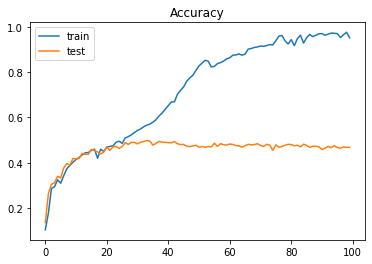

In [256]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['train', 'test'])
plt.title('Accuracy')
plt.show()